## ConvLSTM1.0

Epoch 1/50
9/9 [==============================] - 2s 36ms/step - loss: 0.1904 - val_loss: 0.1823
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1332 - val_loss: 0.1250
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0825 - val_loss: 0.0730
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0446 - val_loss: 0.0424
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0413
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.0405
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0340 - val_loss: 0.0412
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0339 - val_loss: 0.0408
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0333 - val_loss: 0.0393
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0330 - val_loss: 0.0390
Epoch 11/50
9/9 [=====================

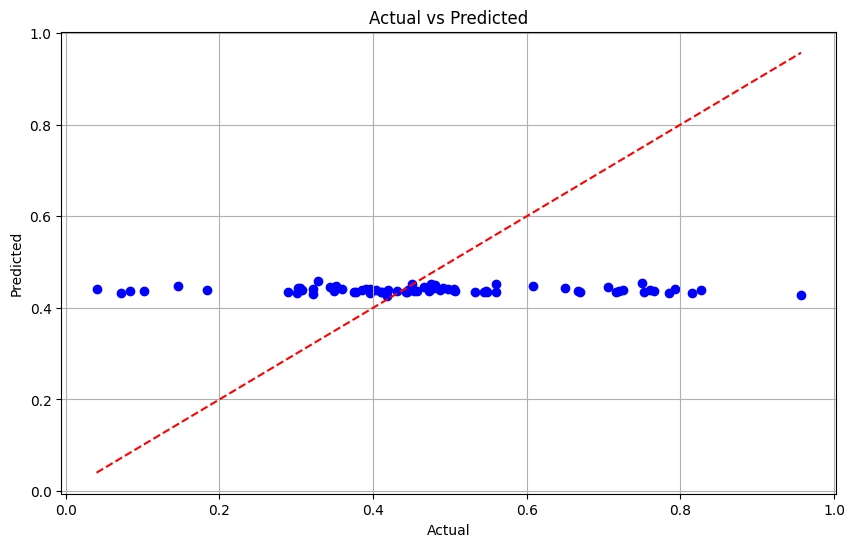

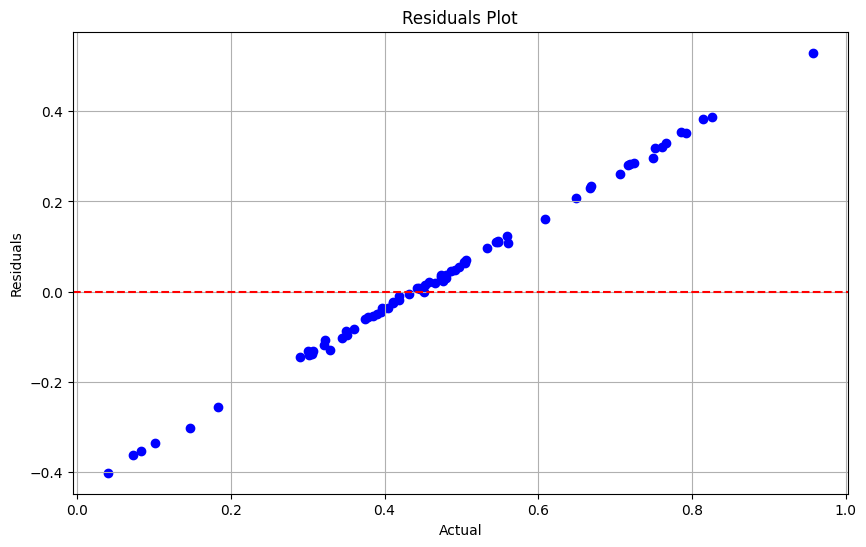

Mean Squared Error: 0.037291448299852585
R-squared: -0.04407115658911942


C:\Users\janak\anaconda3\envs\python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\janak\AppData\Local\Temp\ipykernel_10632\1317981729.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('test_predicted_values.shp')


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from shapely.geometry import Point
import geopandas as gpd

# Load the data from CSV file
data = pd.read_csv(r"C:\Users\janak\ConvLSTM\Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])
# Normalize latitude and longitude
data['latitude_norm'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude_norm'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['latitude_norm', 'longitude_norm', 'activity_index']].iloc[i:i+seq_length].values)
    y.append(data['activity_index'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions and actual labels
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Ensure both have the same number of samples
min_samples = min(len(y_test), len(y_pred))
y_test = y_test[:min_samples]
y_pred = y_pred[:min_samples]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Combine test data with predicted values
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': data['Lat'][-len(y_test):][:min_samples],
                        'Longitude': data['Lon'][-len(y_test):][:min_samples]})

# Save test data and predicted values to CSV
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')


In [3]:
print(gdf.columns)


Index(['Actual_Activity_Index', 'Predicted_Activity_Index', 'Latitude',
       'Longitude', 'geometry'],
      dtype='object')


Index(['Actual_Act', 'Predicted_', 'Latitude', 'Longitude', 'geometry'], dtype='object')


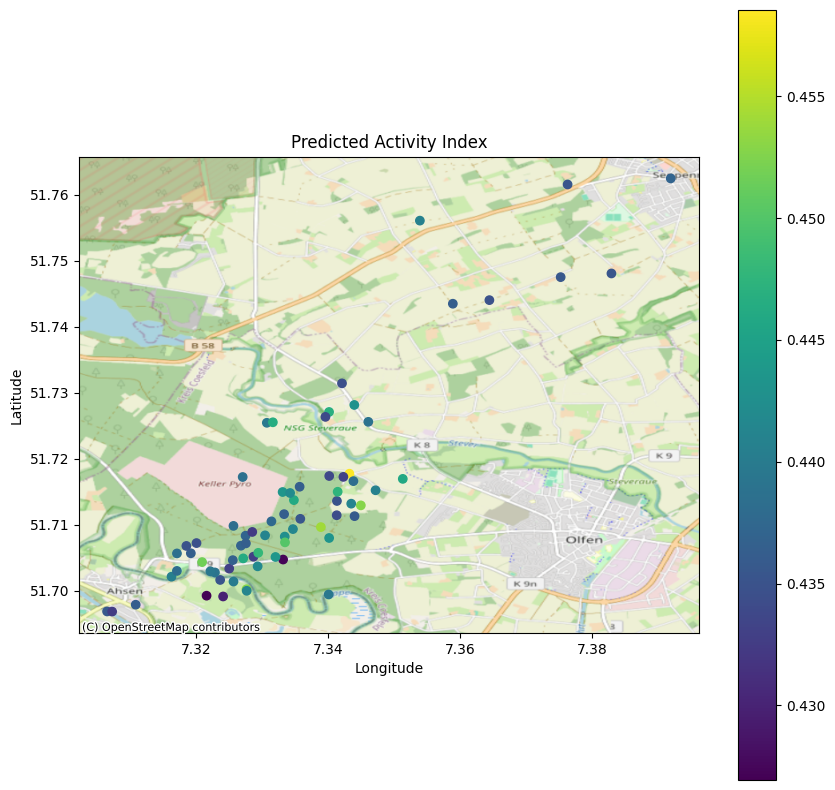

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read the shapefile
gdf = gpd.read_file('test_predicted_values.shp')

# Check the columns in the GeoDataFrame
print(gdf.columns)

# Plot the shapefile with OpenStreetMap (OSM) as the basemap
fig, ax = plt.subplots(figsize=(10, 10))
if 'Predicted_' in gdf.columns:
    gdf.plot(ax=ax, column='Predicted_', legend=True)

# Add OpenStreetMap (OSM) basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Predicted Activity Index')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## ConvLSTM1.1

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam

# Load the data from CSV file
data = pd.read_csv(r"C:\Users\janak\ConvLSTM\Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])
# Normalize latitude and longitude
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
    y.append(data['activity_index'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


Epoch 1/50
9/9 [==============================] - 2s 40ms/step - loss: 0.2682 - val_loss: 0.2720
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2248 - val_loss: 0.2326
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1898 - val_loss: 0.1989
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.1594 - val_loss: 0.1654
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 0.1257 - val_loss: 0.1227
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0813 - val_loss: 0.0689
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0403 - val_loss: 0.0363
Epoch 8/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0349 - val_loss: 0.0371
Epoch 9/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0324 - val_loss: 0.0374
Epoch 10/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0317 - val_loss: 0.0389
Epoch 11/50
9/9 [==================

3/3 [==============================] - 0s 6ms/step


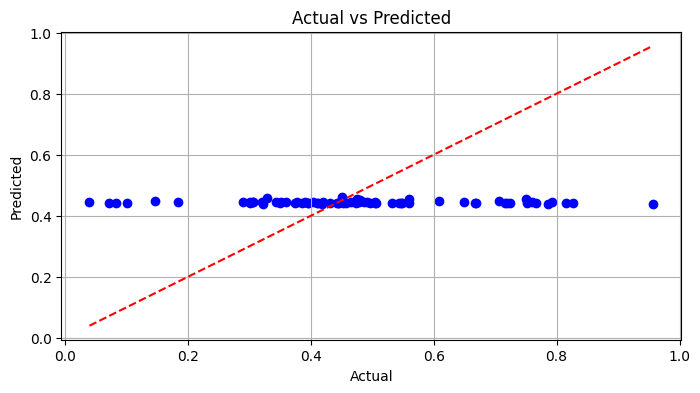

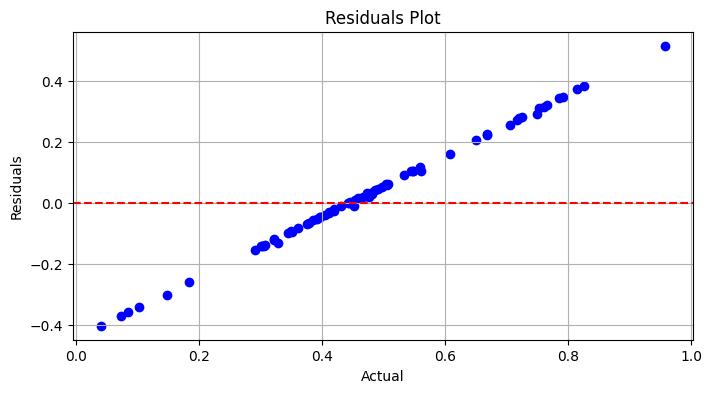

Mean Squared Error: 0.03686098674940902
R-squared: -0.03201926508774977


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you already have the model trained and the test data prepared
# model = trained model
# X_test = test features
# y_test = actual test labels

# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions and actual labels
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Ensure both have the same number of samples
min_samples = min(len(y_test), len(y_pred))
y_test = y_test[:min_samples]
y_pred = y_pred[:min_samples]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)


## ConvLSTM1.2

In [9]:
#!pip install osmnx

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from shapely.geometry import Point
import geopandas as gpd
import osmnx as ox

In [11]:
# Load the data from CSV file
data = pd.read_csv("./Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])

In [14]:
data.head(0)

,ds,Lat,Lon,y,unique_id,date


In [16]:



# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['Lat', 'Lon', 'y']].iloc[i:i+seq_length].values)
    y.append(data['y'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')






In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test).reshape(-1)

# Reshape predictions and actual labels
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Ensure both have the same number of samples
min_samples = min(len(y_test), len(y_pred))
y_test = y_test[:min_samples]
y_pred = y_pred[:min_samples]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Epoch 1/50
9/9 [==============================] - 0s 11ms/step - loss: 7.7889e-05 - val_loss: 8.0201e-05
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 7.9548e-05 - val_loss: 7.8136e-05
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 7.7083e-05 - val_loss: 7.9160e-05
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 7.8283e-05 - val_loss: 7.8953e-05
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 7.7868e-05 - val_loss: 7.8209e-05
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 7.9363e-05 - val_loss: 7.8452e-05
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 7.8591e-05 - val_loss: 7.8491e-05
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 7.8123e-05 - val_loss: 7.8149e-05
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 7.8854e-05 - val_loss: 8.4327e-05
Epoch 10/50
9/9 [==============================] - 0s 8ms/step 

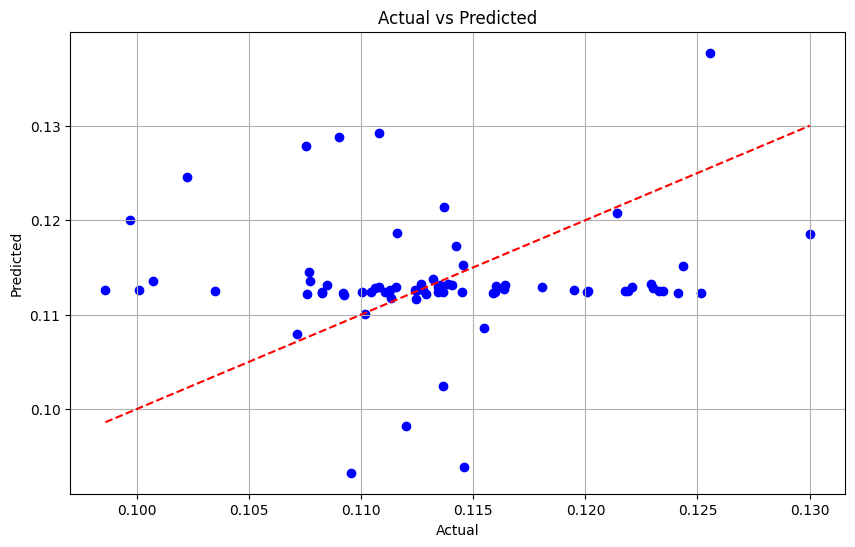

In [25]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

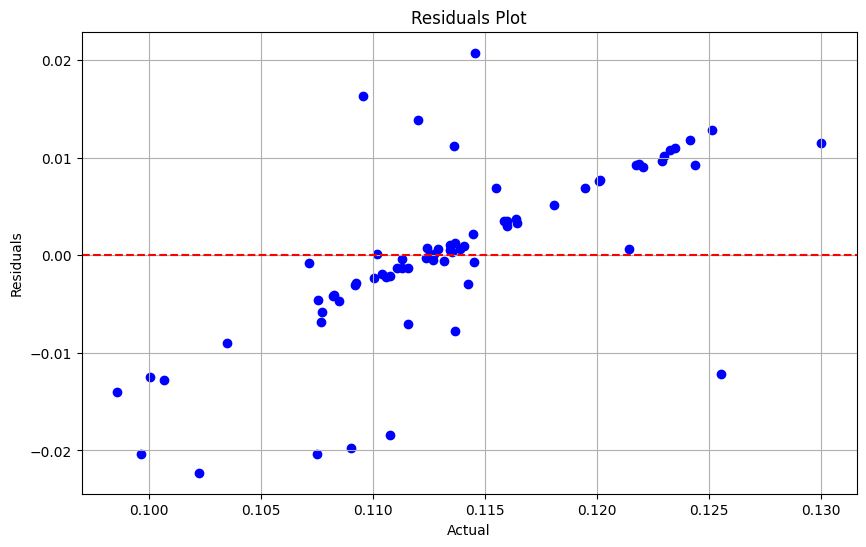

In [23]:
# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [31]:
test_df = pd.DataFrame({'Actual_Index': y_test, 'Pred_Index': y_pred,
                        'Latitude': data['Lat'][-len(y_test):][:min_samples],
                        'Longitude': data['Lon'][-len(y_test):][:min_samples]})
test_df.to_csv(r'./outputs/pred_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file(r'./outputs/pred_values.shp')


C:\Users\janak\anaconda3\envs\python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\janak\AppData\Local\Temp\ipykernel_10632\3964445375.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(r'./outputs/pred_values.shp')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from shapely.geometry import Point
import geopandas as gpd
import osmnx as ox

# Load the data from CSV file
data = pd.read_csv("Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['Lat', 'Lon', 'y']].iloc[i:i+seq_length].values)
    y.append(data['y'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, n_features, 1)
X_test = X_test.reshape(-1, seq_length, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test).reshape(-1)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': X_test[:, -1, 0, 0], 'Longitude': X_test[:, -1, 1, 0]})
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

# Create a random CSV file
random_data = pd.DataFrame({'Lat': np.random.uniform(low=40, high=42, size=100),
                            'Lon': np.random.uniform(low=-75, high=-73, size=100)})
random_data.to_csv('random_data.csv', index=False)

# Predict activity index for random data
random_X = []
for i in range(len(random_data) - seq_length):
    random_X.append(random_data[['Lat', 'Lon']].iloc[i:i+seq_length].values)
random_X = np.array(random_X)
random_X = random_X.reshape(-1, seq_length, n_features, 1)

random_y_pred = model.predict(random_X).reshape(-1)

# Convert predicted output into a shapefile
random_df = pd.DataFrame({'Predicted_Activity_Index': random_y_pred,
                          'Latitude': random_X[:, -1, 0, 0], 'Longitude': random_X[:, -1, 1, 0]})
random_geometry = [Point(xy) for xy in zip(random_df['Longitude'], random_df['Latitude'])]
random_gdf = gpd.GeoDataFrame(random_df, geometry=random_geometry)
random_gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
random_gdf.to_file('random_predicted_values.shp')

# Plot predicted output on OpenStreetMap as a basemap layer
fig, ax = plt.subplots(figsize=(10, 10))
osm_basemap = ox.basemap_to_gdf(ax=ax, bbox=gdf.total_bounds, source=ox.providers.OpenStreetMap.Mapnik)
osm_basemap.plot(ax=ax, alpha=0.5, color='gray')
gdf.plot(ax=ax, column='Predicted_Activity_Index', cmap='viridis', legend=True, legend_kwds={'label': "Predicted Activity Index"})
plt.title('Predicted Activity Index on OpenStreetMap Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
